# Statistics on Decision Tree

We will arange data and train Desicion trees on the data.
The we will try to train again only using quarters from the same cluster (using the quarter classifier).

Our randomly chosen 5 stocks are: 
'SHW', 'MNK', 'BIO', 'KYTH', 'KRO'

# Basic Tree

In [1]:
from Utilities.orginizers import LearningData, TrainingData
from Utilities.confusion_matrix import ConfusionMatrix
from sklearn.model_selection import KFold, cross_val_score
from itertools import product

from multiprocessing import Pool
import matplotlib.pyplot as plt
import Utilities
import numpy as np
import warnings
import logging
import pandas

%matplotlib inline

ld = LearningData()

In [2]:
stock_names = ('SHW', 'MNK', 'BIO', 'KYTH', 'KRO')
logging.getLogger().setLevel(logging.ERROR)
stocks = [TrainingData(sn, ld=ld).add_history(10).set_threshold(0.8).get() for sn in stock_names]

In [3]:
import os
print("Samples per stock:")
print(os.linesep.join(['{} {}'.format(sn, len(data)) for sn, (data, classes) in zip(stock_names, stocks)]))
print("percent of positive classification per stock")
print(os.linesep.join(['{} {}'.format(sn, float(classes.sum())/len(classes)) for sn, (data, classes) in zip(stock_names, stocks)]))
print(stocks[0][0].describe())

Samples per stock:
SHW 7855
MNK 819
BIO 2343
KYTH 718
KRO 3220
percent of positive classification per stock
SHW 0.20038192234245703
MNK 0.1978021978021978
BIO 0.15151515151515152
KYTH 0.201949860724234
KRO 0.20031055900621117
             change        close   ex-divident         high           low  \
count  7.855000e+03  7855.000000  7.855000e+03  7855.000000  7.855000e+03   
mean   2.170977e-17     0.000000  1.447318e-17     0.000000 -1.447318e-16   
std    1.000064e+00     1.000064  1.000064e+00     1.000064  1.000064e+00   
min   -9.826291e-01    -0.711964 -8.285474e-02    -0.708525 -7.122042e-01   
25%   -6.546142e-01    -0.545740 -8.285474e-02    -0.546135 -5.453623e-01   
50%   -2.623907e-01    -0.438244 -8.285474e-02    -0.440260 -4.366827e-01   
75%    3.430775e-01    -0.053682 -8.285474e-02    -0.052620 -5.562959e-02   
max    1.404981e+01     3.669051  2.486545e+01     3.637710  3.656416e+00   

               open   split_ratio        volume  change1_days_before  \
count  7

In [4]:
def run_model(model, inp=stocks):
    matrixes = {sn: [] for sn in stock_names}
    for sn, data in zip(stock_names, inp):
        matrixes[sn] = ConfusionMatrix(data, model)
    return matrixes

def get_best_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if sum([cm.accuracy for cm in accs.values()]) > best_model[0]:
            best_model = (sum([cm.accuracy for cm in accs.values()]), model)
    return best_model

def median(lst):
    quotient, remainder = divmod(len(lst), 2)
    if remainder:
        return sorted(lst)[quotient]
    return sum(sorted(lst)[quotient - 1:quotient + 1]) / 2.

def get_best_median_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if median([cm.accuracy for cm in accs.values()]) > best_model[0]:
            best_model = (median([cm.accuracy for cm in accs.values()]), model)
    return best_model

In [13]:
from sklearn.tree import DecisionTreeClassifier
from pandas import DataFrame
cuts=[]

for i in range(2, 51):
    tmodel = DecisionTreeClassifier()
    tree_stocks = [(pandas.get_dummies(data.apply(lambda s: pandas.qcut(s.rank(method='first'), i))), classes) for data, classes in stocks]
    cms = [ConfusionMatrix(s, tmodel) for s in tree_stocks]
    data = []
    for sn, cm in zip(stock_names, cms):
        data.append((tmodel.criterion, tmodel.max_depth, tmodel.min_samples_leaf, sn, cm.accuracy))
    temp_results = DataFrame(data, columns=('criterion', 'max_depth', 'min_samples', 'stock', 'accuracy'))
    cuts.append((temp_results['accuracy'].mean(), i))
        

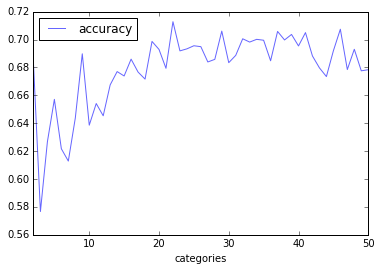

In [14]:
from pandas import DataFrame
res = DataFrame(cuts, columns=['accuracy', 'categories'])
import numpy as np

alpha = 0.6

res = res.set_index('categories')
res.plot(kind='line', label='accuracy', alpha=alpha)
plt.legend(loc='best')

In [15]:
res.loc[res['accuracy'].apply(lambda r: r == res.accuracy.max())]

,accuracy
categories,
22,0.712757


In [16]:
from sklearn.tree import DecisionTreeClassifier

tmodel = DecisionTreeClassifier()
taccs = run_model(tmodel, stocks)
accs = [cm.accuracy for cm in taccs.values()]
accs.sort()
print(sum(accs)/5.)

0.631174282658


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy: 0.7084047433345456


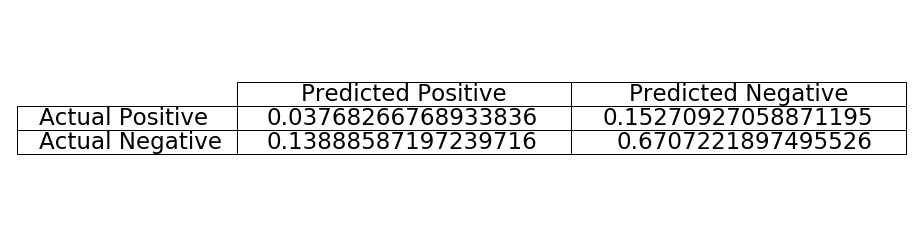

In [21]:
tmodel = DecisionTreeClassifier()
tree_stocks = [(pandas.get_dummies(data.apply(lambda s: pandas.qcut(s.rank(method='first'), 22))), classes) for data, classes in stocks]
cut_accs = run_model(tmodel, tree_stocks)
cm = ConfusionMatrix.concat(iterator=cut_accs.values())
cm.plot()

In [22]:
print(cm.true_acc())

0.21341665826499803


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy: 0.6311742826578988


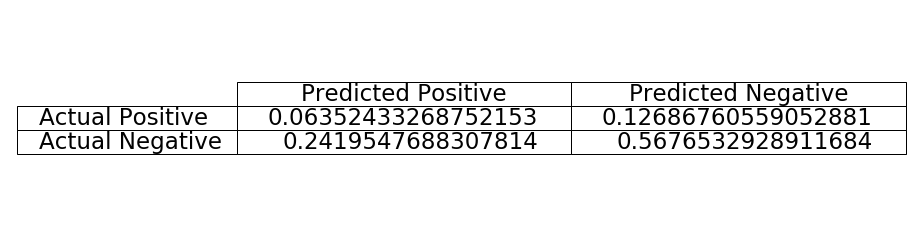

In [19]:
ConfusionMatrix.concat(iterator=taccs.values()).plot()

In [20]:
print(ConfusionMatrix.concat(iterator=taccs.values()).true_acc())

0.2079498478677941


(Not relevant anymore) We got a little less good predictions for positive. This isn't good because it hurts the comparison so we will try to force more positive predictions using weights and see if the accuracy improved.

DecisionTreeClassifier(class_weight={False: 1, True: 1.7}, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy: 0.713992871274923


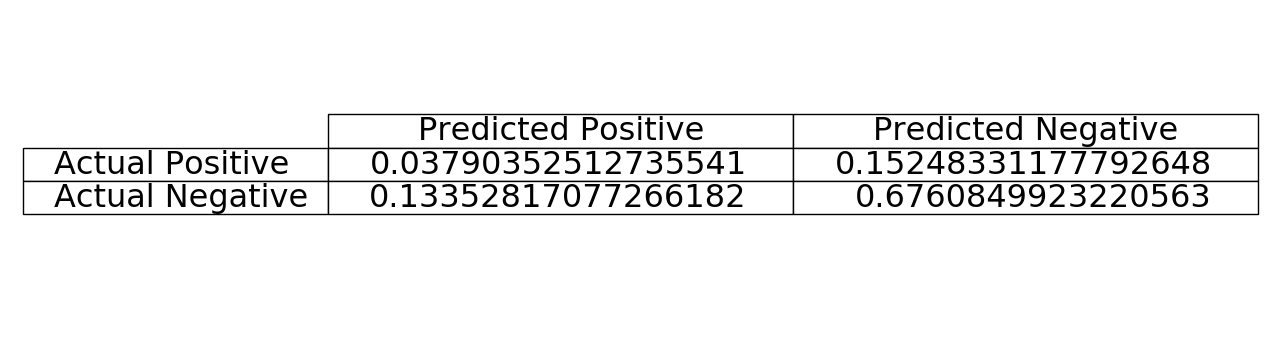

In [43]:
from sklearn.tree import DecisionTreeClassifier
tmodel = DecisionTreeClassifier(class_weight={True:1.7, False:1})
tree_stocks = [(pandas.get_dummies(data.apply(lambda s: pandas.qcut(s.rank(method='first'), 21))), classes) for data, classes in stocks]
cut_accs = run_model(tmodel, tree_stocks)
cm = ConfusionMatrix.concat(iterator=cut_accs.values())
cm.plot()

In [23]:
best_cut=22

In [24]:
from sklearn.tree import DecisionTreeClassifier

# create iterables for all options and use itertools product
# criterion=['gini', 'entropy']
# max_depth=[5, 10, 50]
# using percentages
# min_samples_leaf=[0.005, 0.01, 0.02, 0.05, 0.1]

tree_stocks = [(pandas.get_dummies(data.apply(lambda s: pandas.qcut(s.rank(method='first'), best_cut))), classes) for data, classes in stocks]

# tmodels = [DecisionTreeClassifier(criterion=c, max_depth=md, min_samples_leaf=msl) for c, md, msl in product(criterion, max_depth, min_samples_leaf)]

In [25]:
def run_model_t(model):
    return run_model(model, tree_stocks)

In [50]:
from pandas import DataFrame

def get_results(models):
    accuracies = list(map(run_model_t, models))
    # data should be list of lists and each row should be:
    # criterion, max_depth, min_samples, stock, accuracy
    data = []
    for tmodel, taccs in zip(models, accuracies):
        for tsn, cm in taccs.items():
            data.append((tmodel.criterion, tmodel.max_depth, tmodel.min_samples_leaf, tsn, cm.accuracy, cm.true_acc(), cm.false_acc(), cm.TruePos))
    results = DataFrame(data, columns=('criterion', 'max_depth', 'min_samples', 'stock', 'accuracy', 'positive acc', 'negative acc', 'true positive'))
    return results

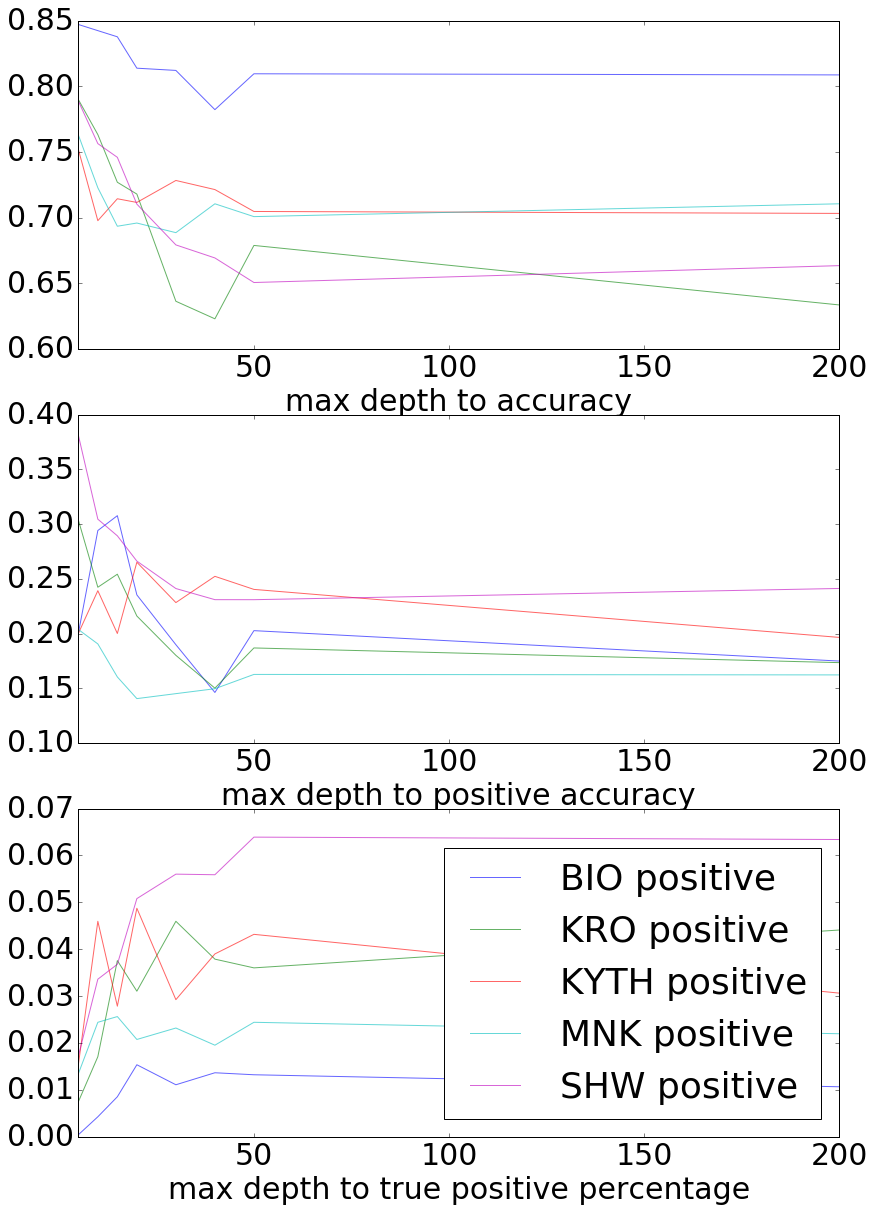

In [54]:
import numpy as np

%matplotlib inline

depths = [5, 10, 15, 20, 30, 40, 50, None]
models = [DecisionTreeClassifier(max_depth=d) for d in depths]
results = get_results(models)

plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((3,2), (0,0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 200).groupby('max_depth').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('max depth to accuracy')

ax2 = plt.subplot2grid((3,2), (1,0))
for name, group in results.groupby('stock'):
    group.replace(np.nan, 200).groupby('max_depth').agg('mean')['positive acc'].plot(kind='line', label=name+' positive', alpha=alpha)
ax2.set_xlabel('max depth to positive accuracy')

ax3 = plt.subplot2grid((3,2), (2,0))
for name, group in results.groupby('stock'):
    group.replace(np.nan, 200).groupby('max_depth').agg('mean')['true positive'].plot(kind='line', label=name+' positive', alpha=alpha)
ax3.set_xlabel('max depth to true positive percentage')

plt.legend(loc='best')


In [58]:
min_samples = [1, 2, 5, 10, 15, 20, 30, 40]
models = [DecisionTreeClassifier(min_samples_leaf=m) for m in min_samples]
results = get_results(models)

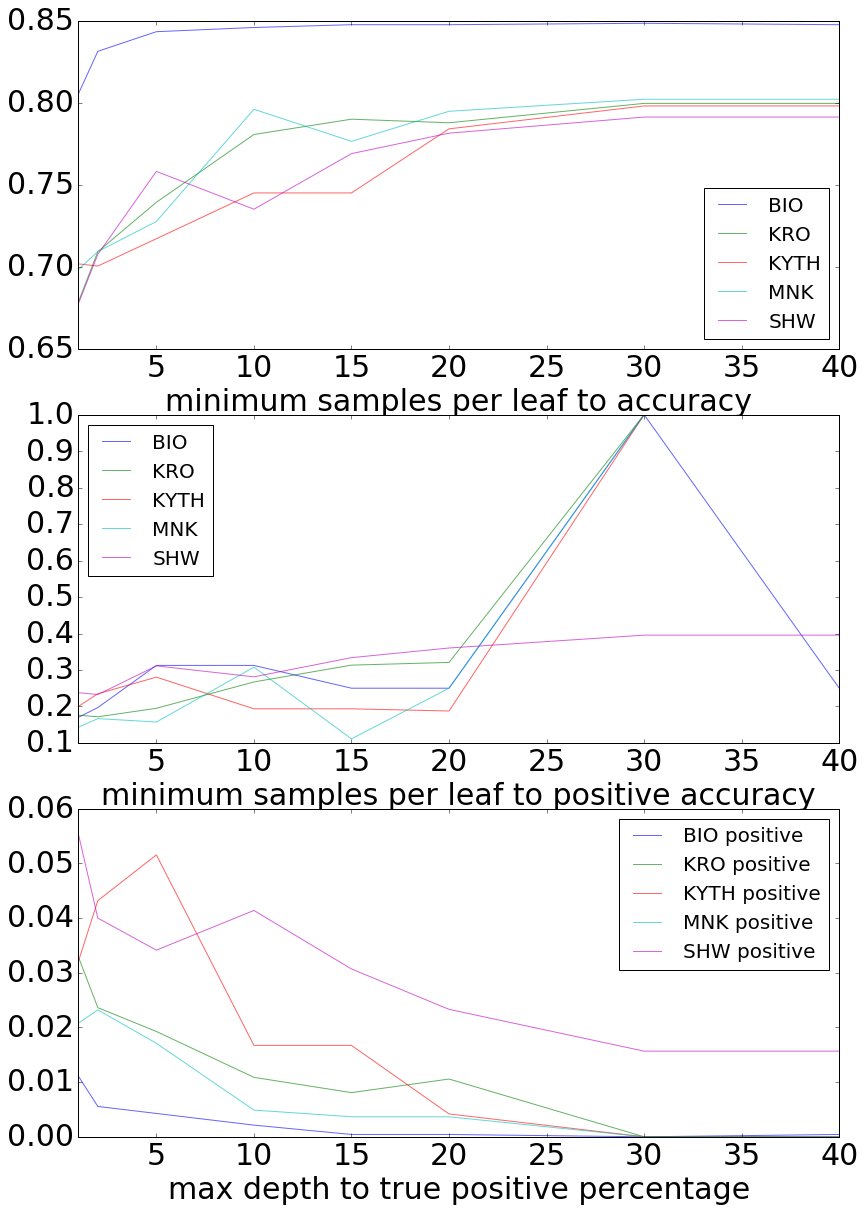

In [57]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((3,2), (0,0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('min_samples').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('minimum samples per leaf to accuracy')
plt.legend(loc='best', prop={'size':20})

ax2 = plt.subplot2grid((3,2), (1, 0))
for name, group in results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('min_samples').agg('mean')['positive acc'].plot(kind='line', label=name, alpha=alpha)
ax2.set_xlabel('minimum samples per leaf to positive accuracy')
plt.legend(loc='best', prop={'size':20})

ax3 = plt.subplot2grid((3,2), (2,0))
for name, group in results.groupby('stock'):
    group.replace(np.nan, 200).groupby('min_samples').agg('mean')['true positive'].plot(kind='line', label=name+' positive', alpha=alpha)
ax3.set_xlabel('max depth to true positive percentage')
plt.legend(loc='best', prop={'size':20})

In [59]:
criterion = ['gini', 'entropy']
models = [DecisionTreeClassifier(criterion=c) for c in criterion]
results = get_results(models)

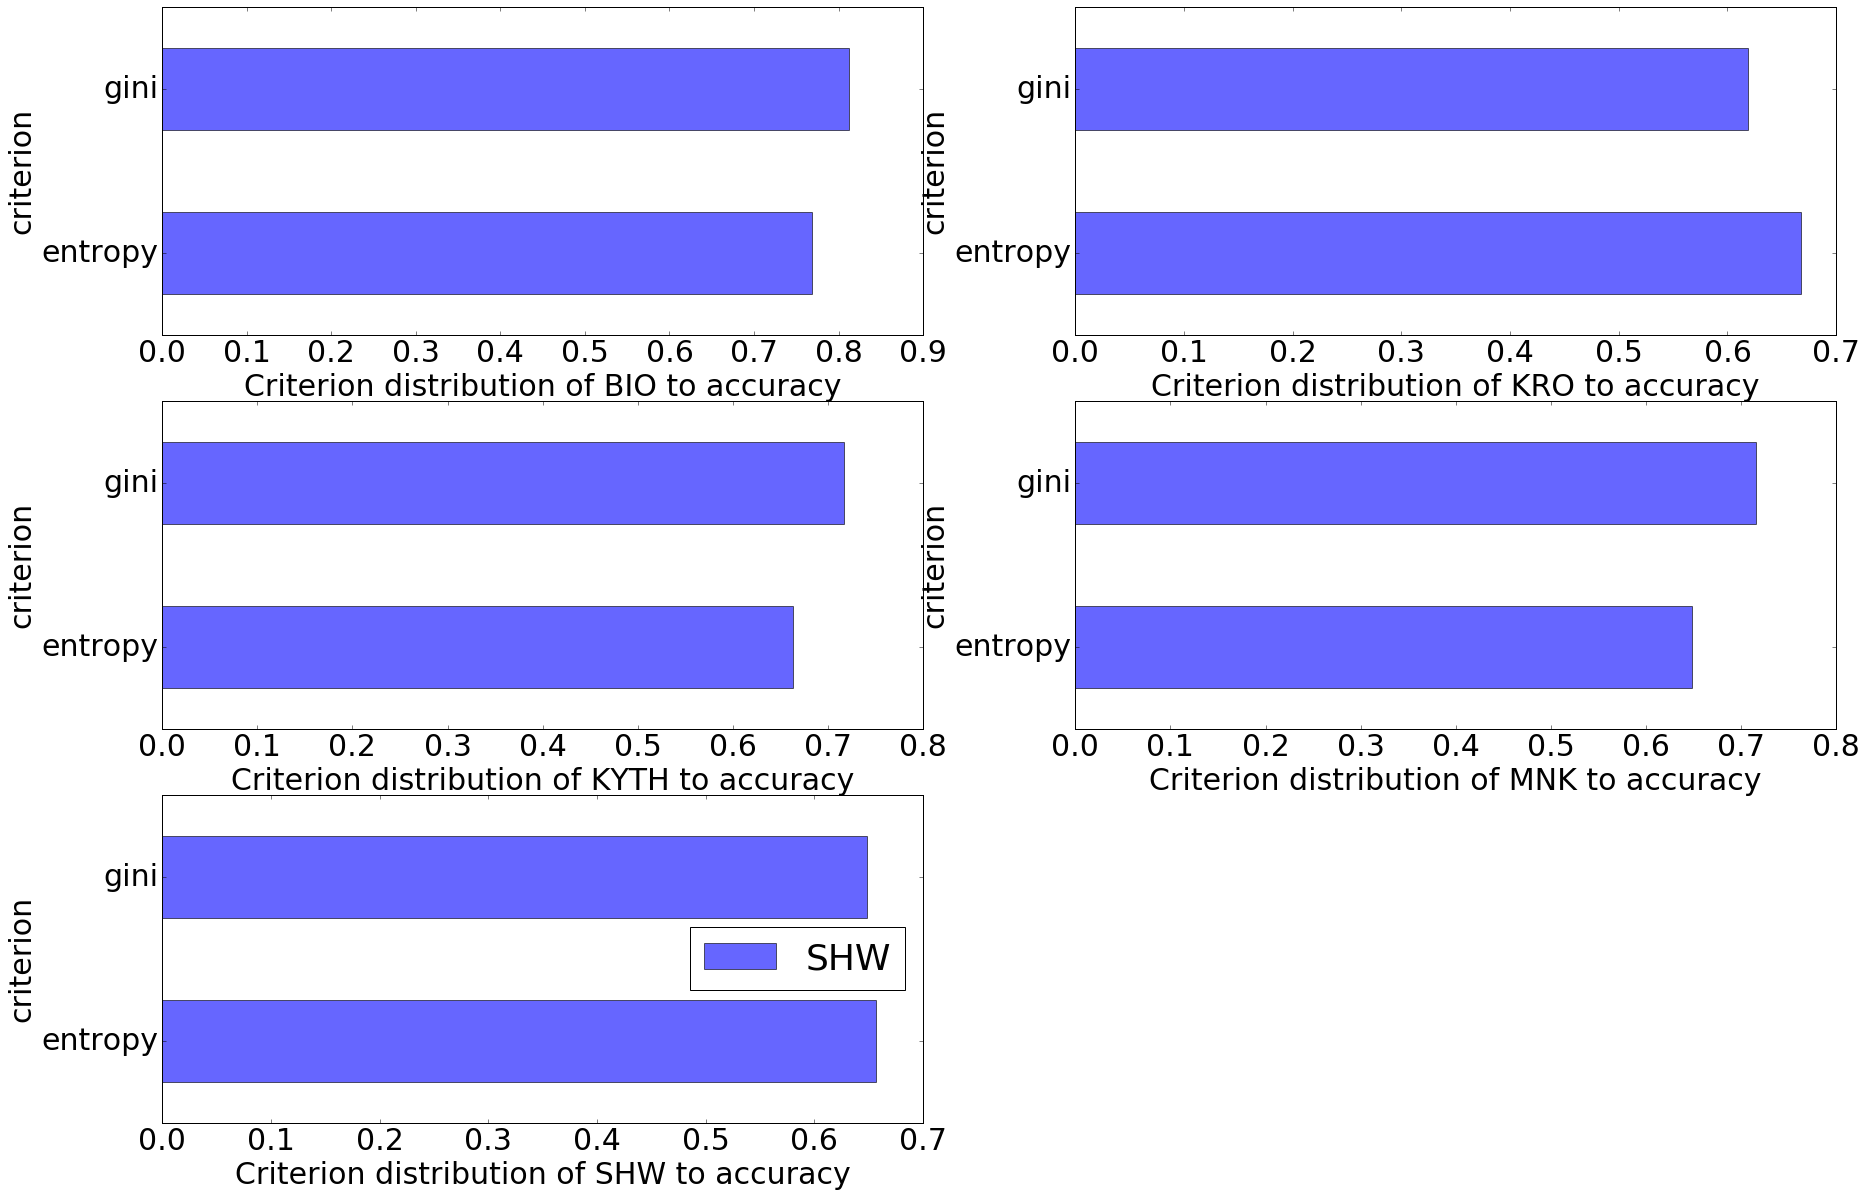

In [60]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(results.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('criterion').agg('mean')['accuracy'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('Criterion distribution of ' + name + ' to accuracy')
plt.legend(loc='best')


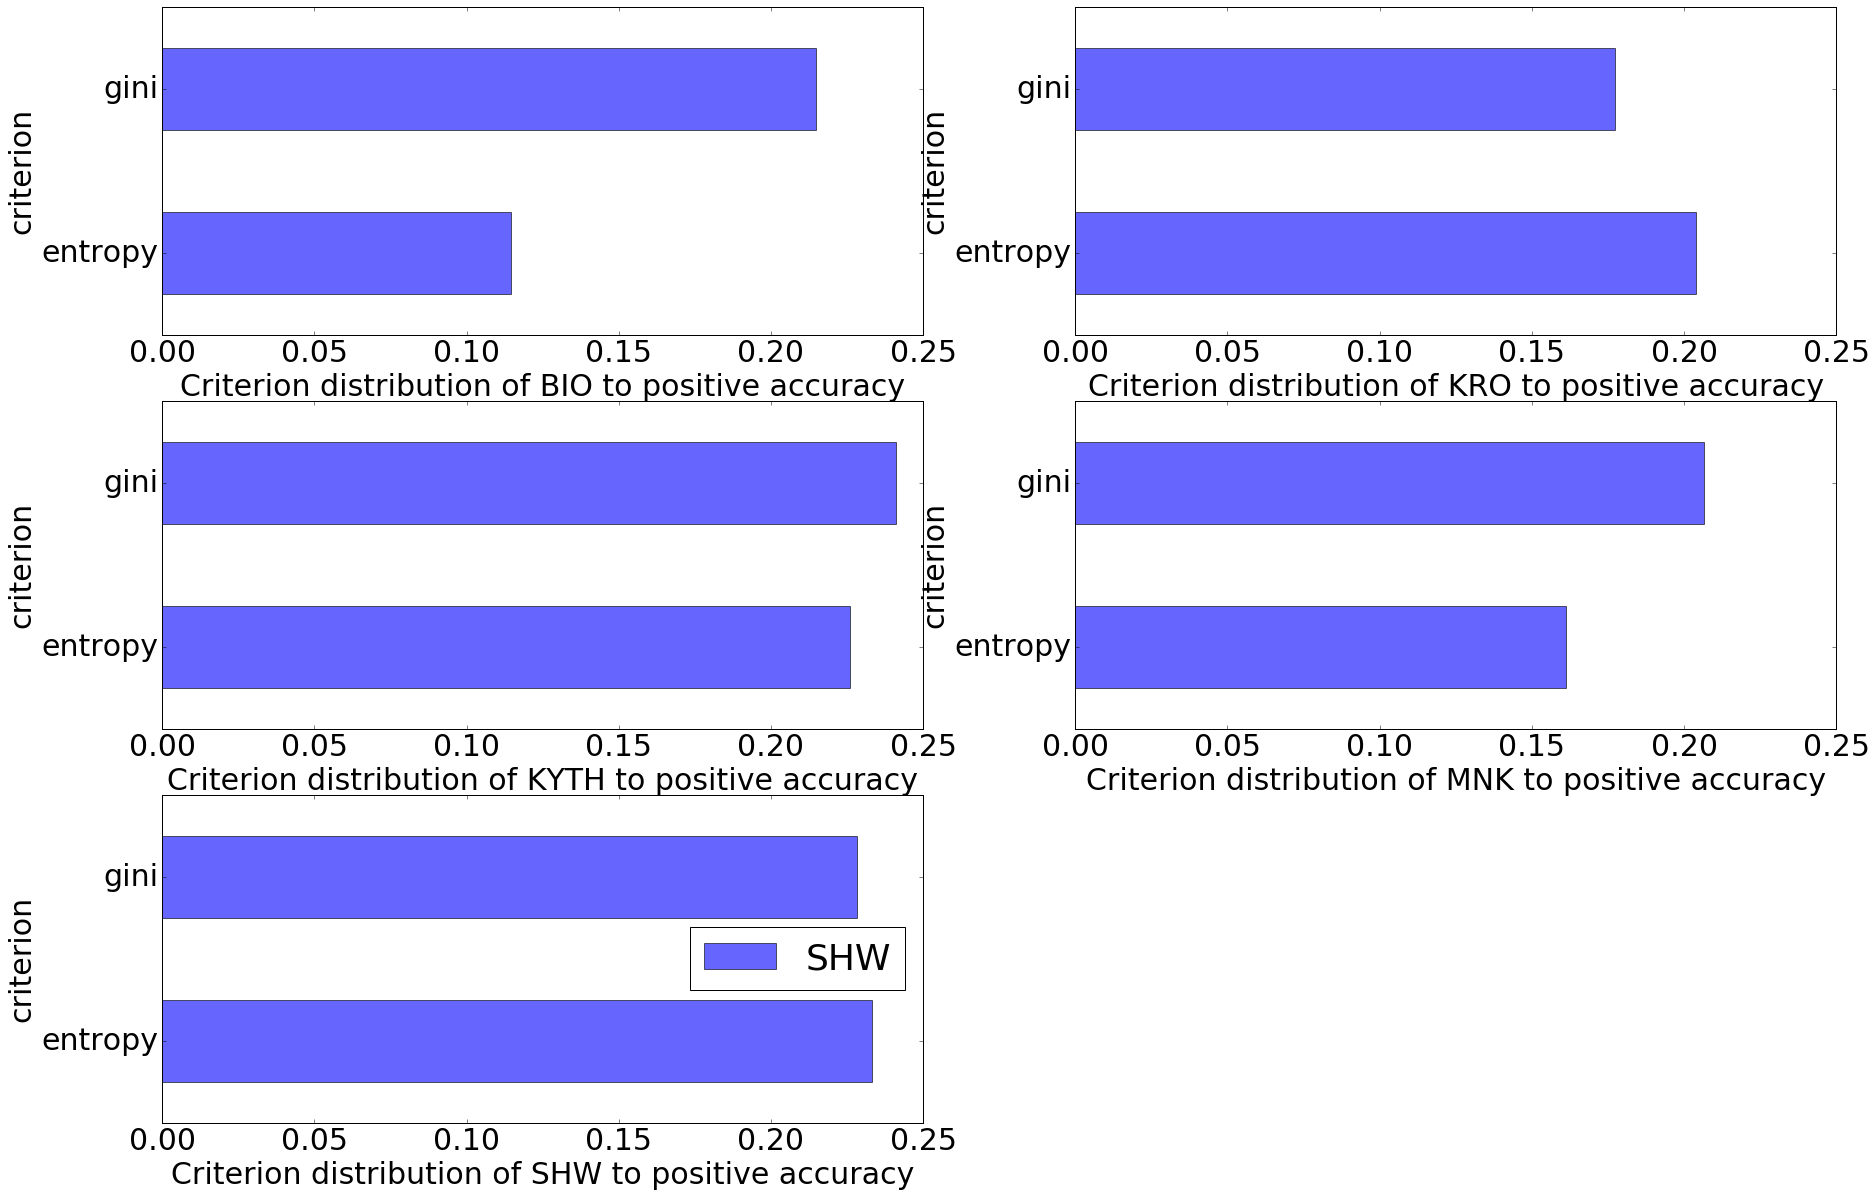

In [61]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(results.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('criterion').agg('mean')['positive acc'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('Criterion distribution of ' + name + ' to positive accuracy')
plt.legend(loc='best')

Too high positive accurac. Want to check negative accuracy for sanity check

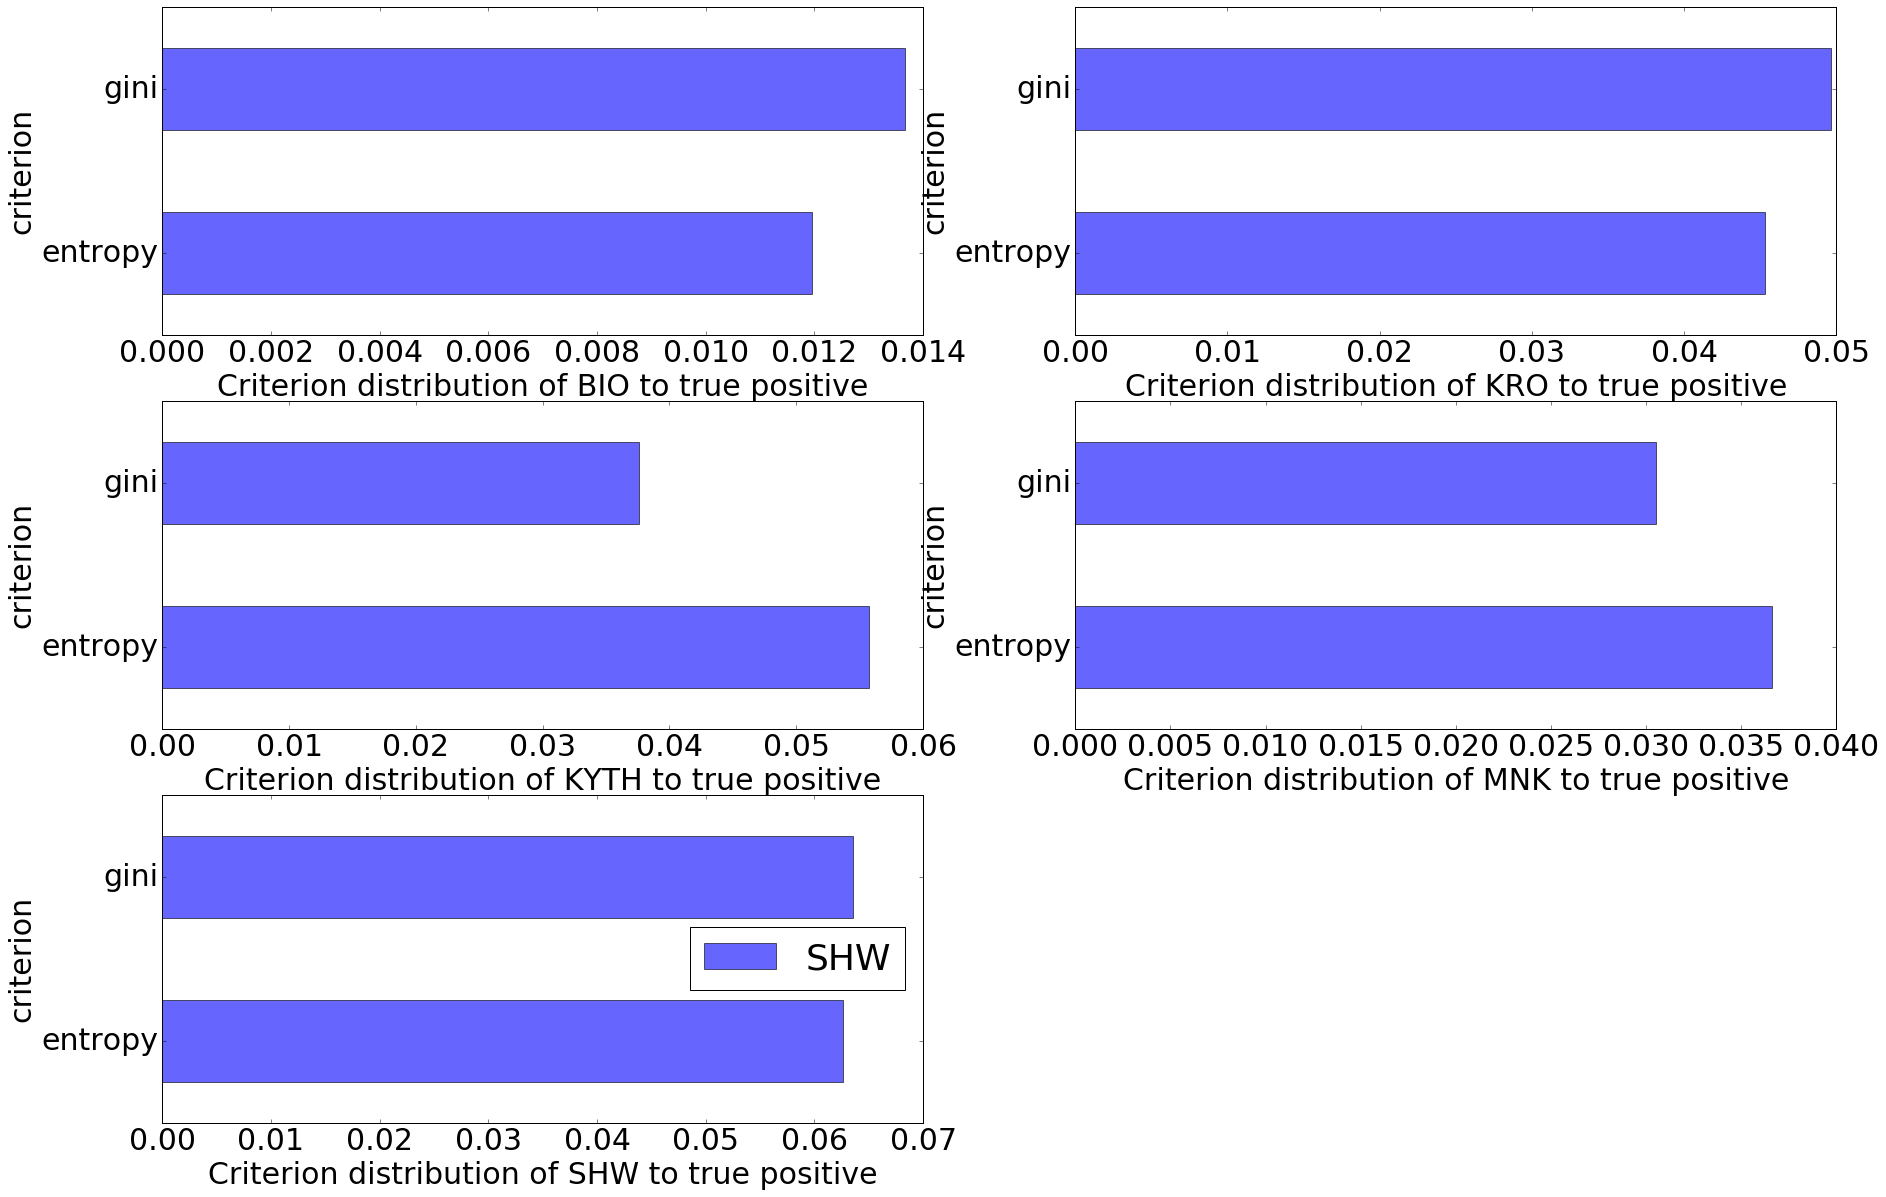

In [62]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(results.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('criterion').agg('mean')['true positive'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('Criterion distribution of ' + name + ' to true positive')
plt.legend(loc='best')

The best average accuracy model is:

In [65]:
print(get_best_model(tmodels, taccuracies))
print(get_best_median_model(tmodels, taccuracies))

(4.0481285623295049, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))
(0.79968101409056913, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy: 0.802197802198


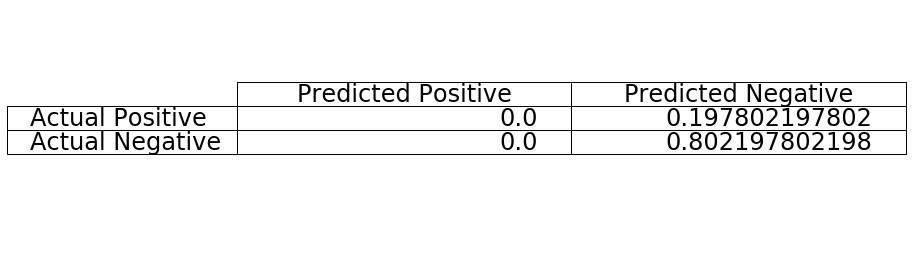

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy: 0.799617795676


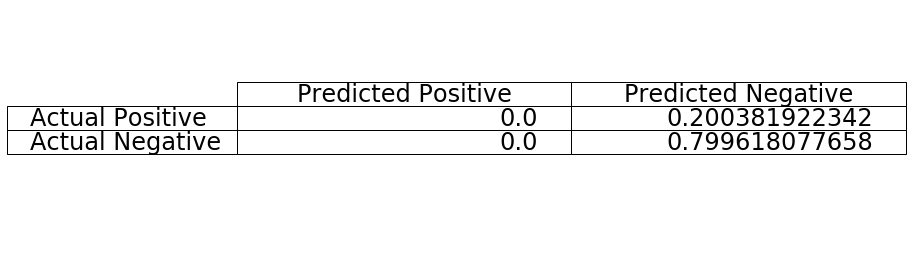

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy: 0.848484848485


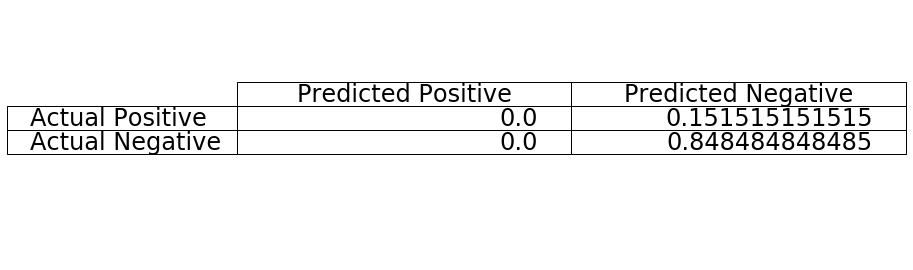

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy: 0.799681014091


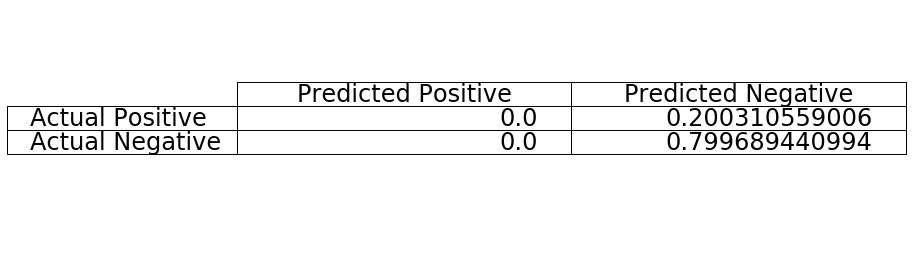

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy: 0.798117154812


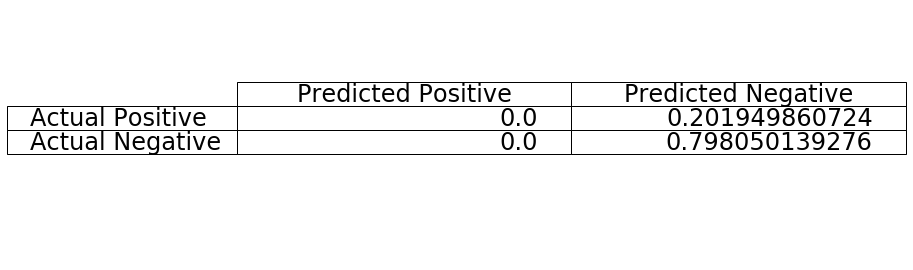

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy: 0.8096197230521897


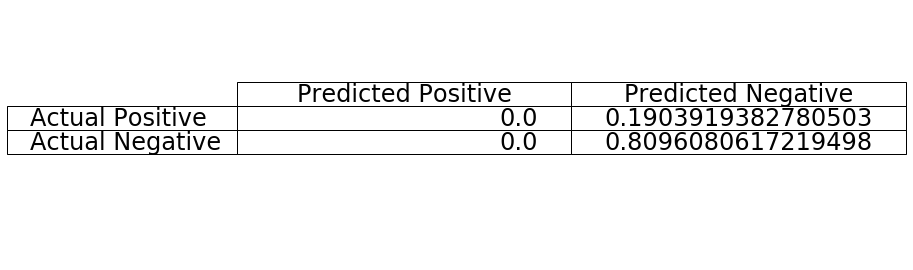

In [44]:
best = get_best_model(tmodels, taccuracies)[1]
best = taccuracies[tmodels.index(best)]
for cm in best.values():
    cm.plot()
best = ConfusionMatrix.concat(*list(best.values()))
best.plot()

Which is like just saying always false. we cant work with it because we use adaboost later on we need something that works. An important note is that we don't want to increase the amount of samples per leaf or decrease max depth as the classifier will be meaningless. Even we prefer to look at less samples per leaf so we will have more then 20 leaves:

In [45]:
t2combined = [(model, accs) for model, accs in zip(tmodels, taccuracies) if model.min_samples_leaf < 0.05]
t2models = [top[0] for top in t2combined]
t2accuracies = [top[1] for top in t2combined]

print(get_best_model(t2models, t2accuracies))
print(get_best_median_model(t2models, t2accuracies))

(3.9925617921403873, DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.01,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))
(0.79961779567601277, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.02,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.02,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy: 0.788766788767


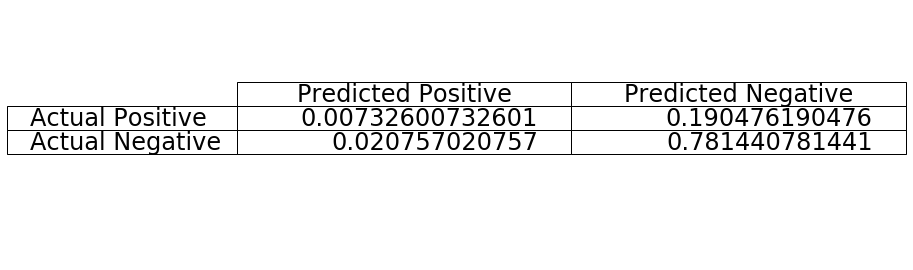

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.02,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy: 0.799617795676


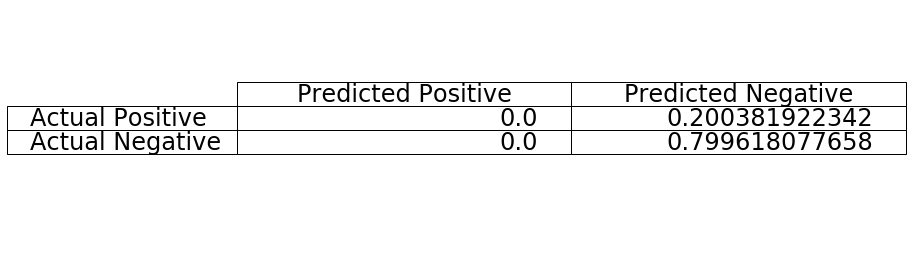

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.02,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy: 0.848484848485


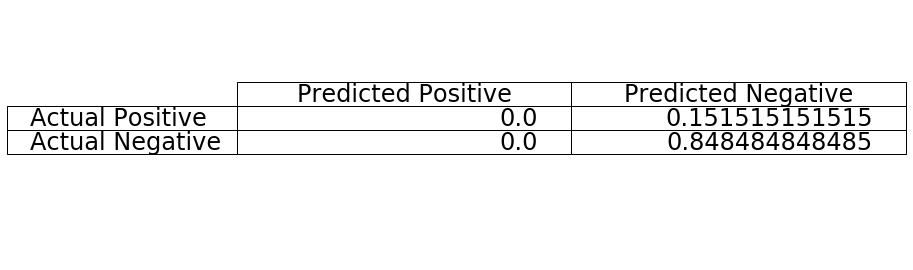

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.02,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy: 0.799681014091


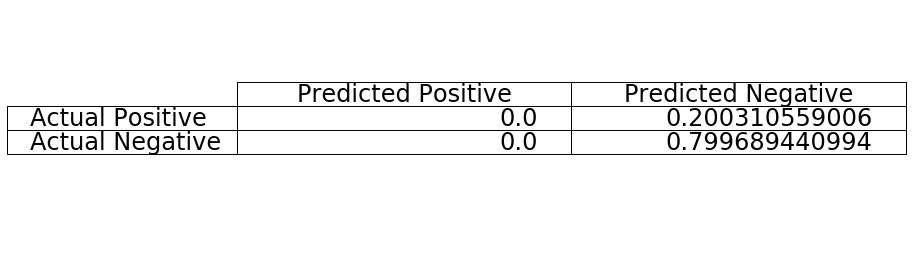

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.02,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy: 0.747907949791


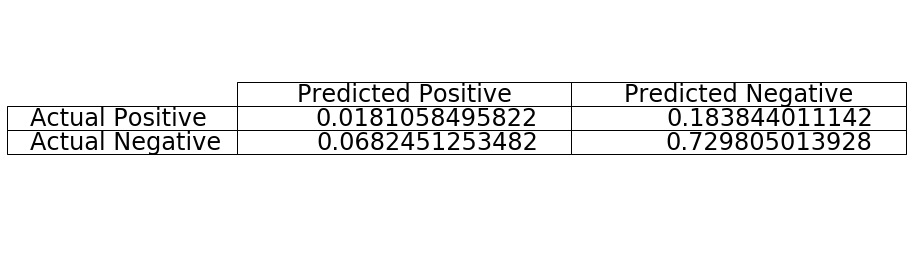

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.02,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy: 0.7968916793618028


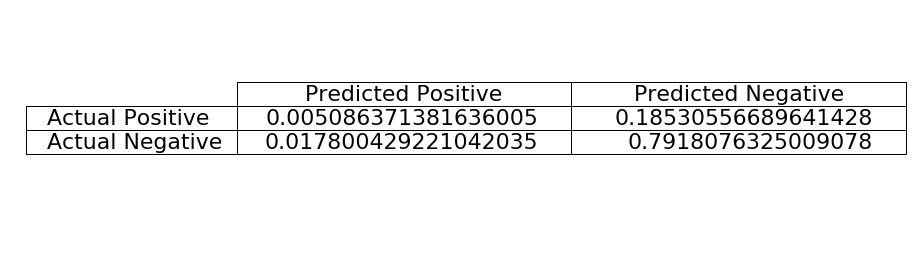

In [47]:
t2combined = [(model, accs) for model, accs in zip(tmodels, taccuracies) if model.min_samples_leaf < 0.05 and model.max_depth > 5]
t2models = [top[0] for top in t2combined]
t2accuracies = [top[1] for top in t2combined]
best = get_best_model(t2models, t2accuracies)[1]
best = t2accuracies[t2models.index(best)]
for cm in best.values():
    cm.plot()
best = ConfusionMatrix.concat(*list(best.values()))
best.plot()

# Variance Reduction
We will try 3 approches. 

    1. using standard sklearn feature selection. 
    2. using QuarterClusterer try using data with less variance.
    3. using relation strength classifier.

In [6]:
import sklearn.tree 
accs = run_model(sklearn.tree.DecisionTreeClassifier())

In [7]:
print(sum(accs.values()))

2.44557153431


## Standard feature selection

We have plenty of samples so it seems wiser to use mutual_info score func, and trying to remove features by those who have small variance.

In [63]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

results = []
for i in range(1, 121, 10):
    filtered_tree_stocks = [(SelectKBest(score_func=mutual_info_classif, k=i).fit_transform(data, classes), classes) for data, classes in tree_stocks]
    results.append((i, sum(run_model(DecisionTreeClassifier(), filtered_tree_stocks).values())))
    
results.sort(key=lambda t: t[1])
for t in results[:10]:
    print('{} {}'.format(t[0],t[1]))


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [ ]:
from sklearn.feature_selection import VarianceThreshold

results2 = []
for i in range(1, 11):
    try:
        filtered_tree_stocks = [(VarianceThreshold(threshold=float(i)/100).fit_transform(data, classes), classes) for data, classes in tree_stocks]
        results2.append((i, sum(run_model(DecisionTreeClassifier(), filtered_tree_stocks).values())))
    except Exception as e:
        print('Skipping threshold {} as it doesnt have enough variance: {}'.format(float(i)/100, str(e)))
    
results2.sort(key=lambda t: t[1])
for t in results2:
    print('{} {}'.format(t[0],t[1]))

# Using the Quarter Classifier

The idea is that some quarters behave the same and so we can really decrease our data's variance if we cluster them together and then try to predict with the narowred down data.

In [43]:
from Classifiers import classifiers

quarterizer = classifiers.Quarterizer().fit(stocks[0][0])
quarters = pandas.concat([quarterizer.transform(d) for d,c in stocks])
quarters.describe()

,0,1,2,3,4,5,6,7,8,9,...,712,713,714,715,716,717,718,719,720,721
count,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,...,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000
mean,-1.166515,-1.160028,-1.153850,-1.148183,-1.143229,-1.139189,-1.136266,-1.134661,-1.134576,-1.136045,...,-0.567933,-0.445574,-0.327797,-0.220037,-0.127017,-0.053462,-0.003060,0.024629,0.031082,0.017774
std,2.697344,2.695870,2.716602,2.741835,2.762661,2.775970,2.781992,2.782545,2.779904,2.776307,...,5.862200,6.001641,6.110431,6.228944,6.367522,6.496243,6.565312,6.536801,6.374755,6.042730
min,-7.180453,-7.081043,-7.237665,-7.883670,-8.237539,-8.337366,-8.221242,-7.927261,-7.493517,-6.958100,...,-9.693521,-10.968565,-11.948655,-12.537482,-12.638734,-12.156099,-10.993268,-9.053928,-7.736395,-7.671360
25%,-2.843656,-2.843992,-2.843055,-2.845738,-2.848458,-2.850582,-2.862501,-2.848320,-2.840663,-2.848786,...,-2.970533,-2.955282,-2.956861,-2.901402,-2.911704,-2.887583,-2.875127,-2.870263,-2.870554,-2.831041
50%,-2.584973,-2.600785,-2.614316,-2.584422,-2.599009,-2.597153,-2.593953,-2.591194,-2.599746,-2.604249,...,-2.215353,-2.221403,-2.063798,-2.052390,-2.011536,-2.112609,-2.189342,-2.065904,-2.038702,-1.972767
75%,1.946519,2.002208,1.961620,1.913106,1.929182,1.987506,2.048697,2.045505,2.088920,2.119520,...,0.739899,0.742141,1.090213,1.352441,1.172843,1.389354,1.539184,1.424363,1.433567,1.233152
max,4.602059,4.935822,5.230256,5.508054,5.794210,6.021569,6.191266,6.304439,6.362222,6.368024,...,69.139259,68.043155,64.494012,58.977252,51.978296,48.640885,52.352624,54.136662,53.559761,50.188682


In [44]:
from sklearn.cluster import KMeans

clusters = 6
q_clf = KMeans(n_clusters=clusters).fit(quarters.drop(['start', 'end'], axis=1))

In [45]:
q_data = [quarterizer.transform(d) for d, c in stocks]
c_stocks = [(d, q_clf.predict(d.drop(['start', 'end'], axis=1))) for d in q_data]

combined = []
for d, c in stocks:
    d2 = d.copy(False)
    d2['class'] = c
    combined.append(d2)
by_classes = [quarterizer.cut_by_classes(d, qs,  qcs) for d, (qs, qcs) in zip(combined, c_stocks)]

In [53]:
def run_clustered_model(model, class_dict=by_classes):
    scores = {}
    for sn, d_dict in zip(stock_names, class_dict):
        scores[sn] = 0
        for c in d_dict.keys():
            data, classes = d_dict[c].drop('class', axis=1), d_dict[c]['class']
            if classes.isnull().sum() > 0:
                print("filling na: {}".format(classes.isnull().sum()))
                classes = classes.fillna(classes.median())
            if len(classes.unique()) == 1:
                scores[sn] += 0.8
            else:
                classes = list(classes)
                try:
                    scores[sn] += sum(cross_val_score(model, data, classes))/3
                except Exception as e:
                    print(sn, c)
                    print(classes)
                    print(str(e))
        scores[sn] /= len(d_dict)
    return scores

In [54]:
s_cluster_accuracies = run_clustered_model(DecisionTreeClassifier())

filling na: 1


In [56]:
print(s_cluster_accuracies)

{'SHW': 0.9996690288756459, 'KRO': 0.95634066318620869, 'KYTH': 0.99384920634920637, 'BIO': 0.9949425581502489, 'MNK': 0.9917046076813324}


In [55]:
print(get_best_model([DecisionTreeClassifier()], [s_cluster_accuracies]))
print(get_best_median_model([DecisionTreeClassifier()], [s_cluster_accuracies]))

(4.9365060642426419, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))
(0.99384920634920637, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))


## Connection Strength Classifier

In [ ]:
from Utilities.clustering import StrengthCalc

sc = StrengthCalc()

In [ ]:
from Classifiers.classifiers import ConnectionStrengthClassifier

# dictionary of market name to strength
stock_strengths = [sc.get_strength_stock(sn, 5, 325, 2, 0.1) for sn in stock_names]

clf = ConnectionStrengthClassifier()

In [ ]:
from Utilities import clean_market_name

cols = []
for d, c in stocks:
    cols.extend(d.columns)
all_cols = set(cols)

strengths = []
connections_cols = []
for i, sn in enumerate(stock_names):
    cur_cols = []
    cur_strengths = []
    for m in ld.get_market_names():
        cur_cols.append(list(filter(lambda c: clean_market_name(m) in c, all_cols)))
        cur_strengths.append(stock_strengths[i][m])
    connections_cols.append(cur_cols)
    strengths.append(cur_strengths)

In [ ]:
def run_strength_model(model, stocks=stocks, strength=strengths, cols=connections_cols):
    scores = {sn: [] for sn in stock_names}
    for sn, (data, classes), st, cs in zip(stock_names, tree_stocks, strength, cols):
        fit_params = {'connection_columns': cs, 'strengths': st}
        scores[sn] = (sum(cross_val_score(model, data, classes, fit_params=fit_params))/3) 
    return scores

In [ ]:
import Classifiers.classifiers
import sklearn.tree

model = Classifiers.classifiers.ConnectionStrengthClassifier(base_estimator=sklearn.tree.DecisionTreeClassifier())
st_accuracies = run_strength_model(model)

In [ ]:
print(st_accuracies)
print(sum(st_accuracies.values()))

In [ ]:
import Classifiers
import sklearn
from itertools import product

thresholds = [0.001, 0.05, 0.1, 0.15]
combined_weights = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
base_strength = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# t_models = [Classifiers.classifiers.ConnectionStrengthClassifier(threshold=t, base_estimator=sklearn.tree.DecisionTreeClassifier()) for t in thresholds]
# c_models = [Classifiers.classifiers.ConnectionStrengthClassifier(combined_weight=c, base_estimator=sklearn.tree.DecisionTreeClassifier()) for c in combined_weights]
sct_models = [Classifiers.classifiers.ConnectionStrengthClassifier(threshold=t, base_strength=bs, combined_weight=w, 
                                                                   base_estimator=sklearn.tree.DecisionTreeClassifier()) 
          for t, w, bs in product(thresholds, combined_weights, base_strength)]

In [ ]:
sct_accuracies = list(map(run_strength_model, sct_models))

In [ ]:
print(get_best_model(sct_models, sct_accuracies))
print(get_best_median_model(sct_models, sct_accuracies))

## Analyze strength classifier results

In [39]:
from pandas import DataFrame

# data should be list of lists and each row should be:
# criterion, max_depth, min_samples, stock, accuracy
data = []
for tmodel, taccs in zip(sct_models, sct_accuracies):
    for tsn, tacc in taccs.items():
        data.append((tmodel.base_strength, tmodel.combined_weight, tmodel.threshold, tsn, tacc))
sct_results = DataFrame(data, columns=('base_strength', 'combined_weight', 'threshold', 'stock', 'accuracy'))

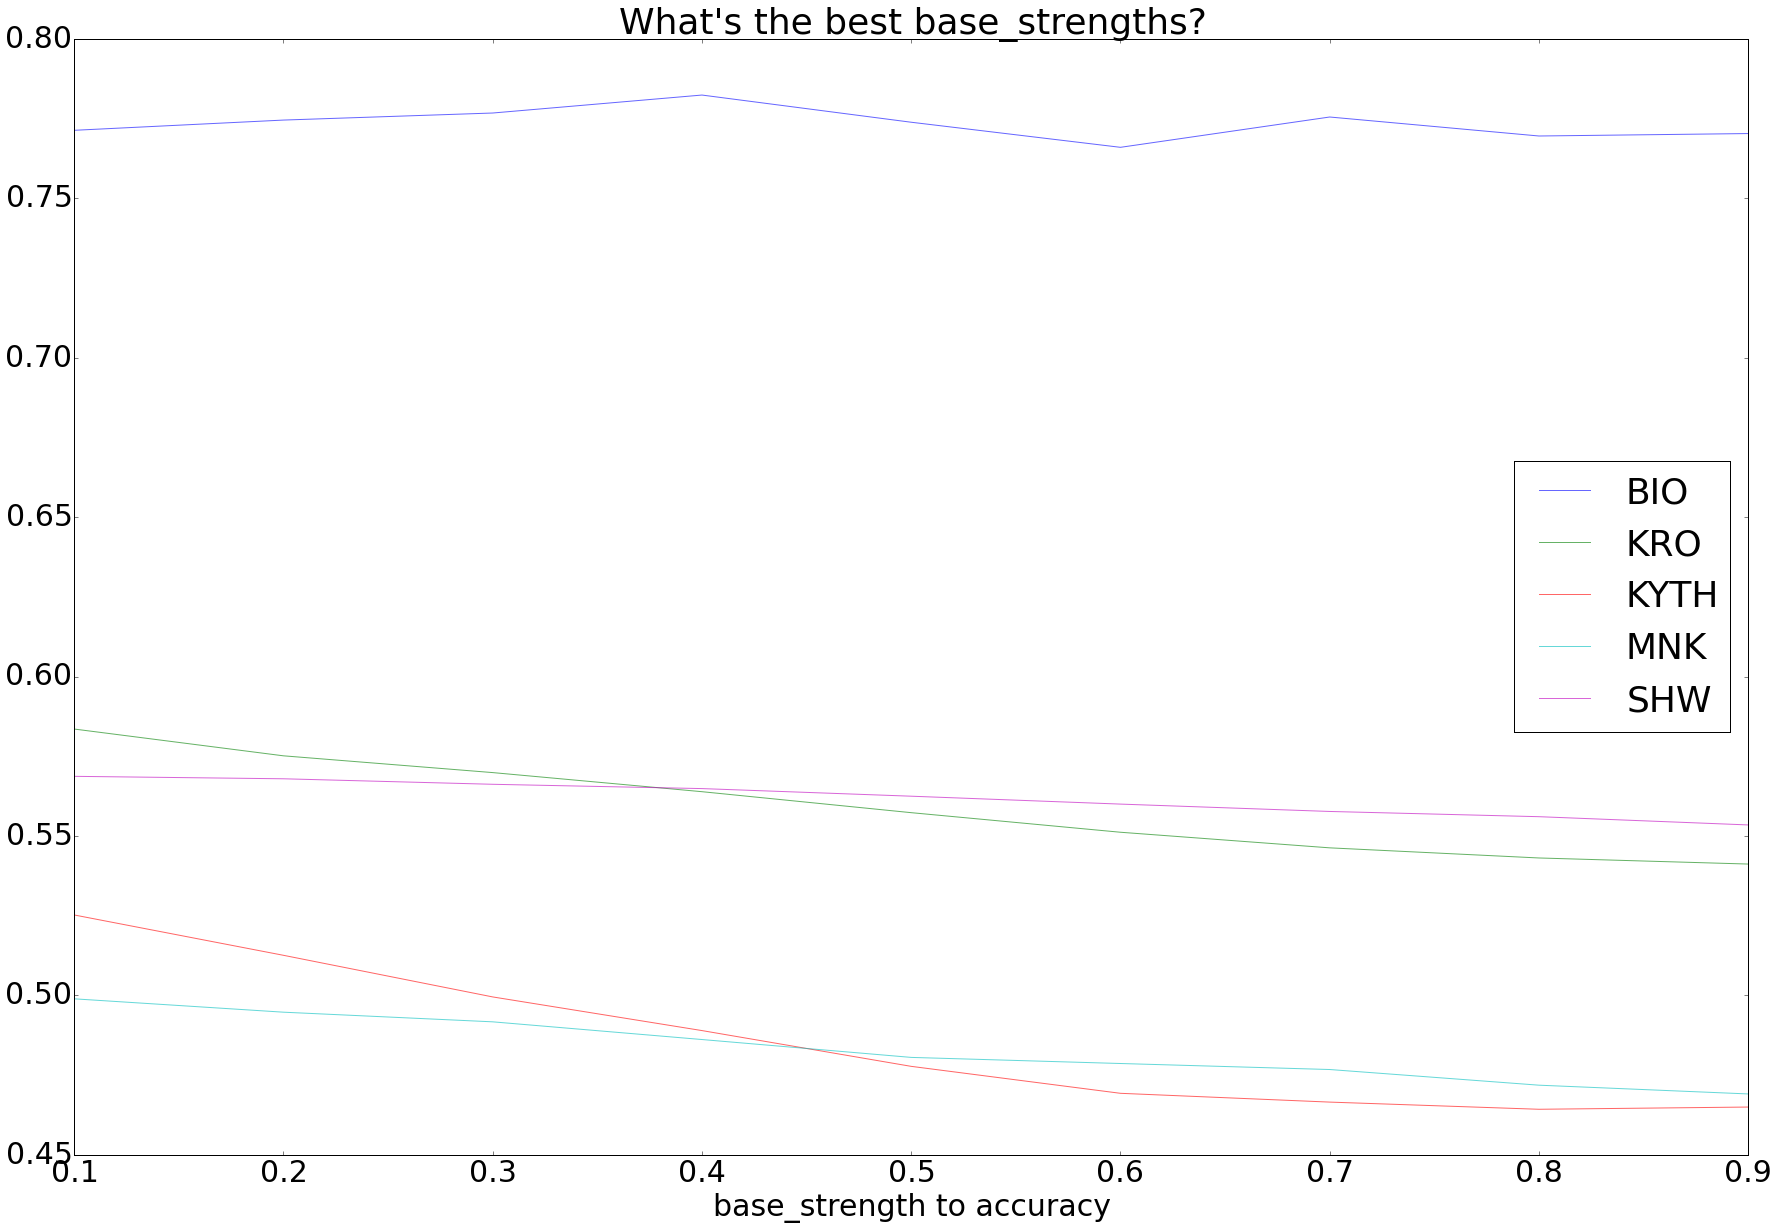

In [40]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in sct_results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('base_strength').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('base_strength to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best base_strengths?" )

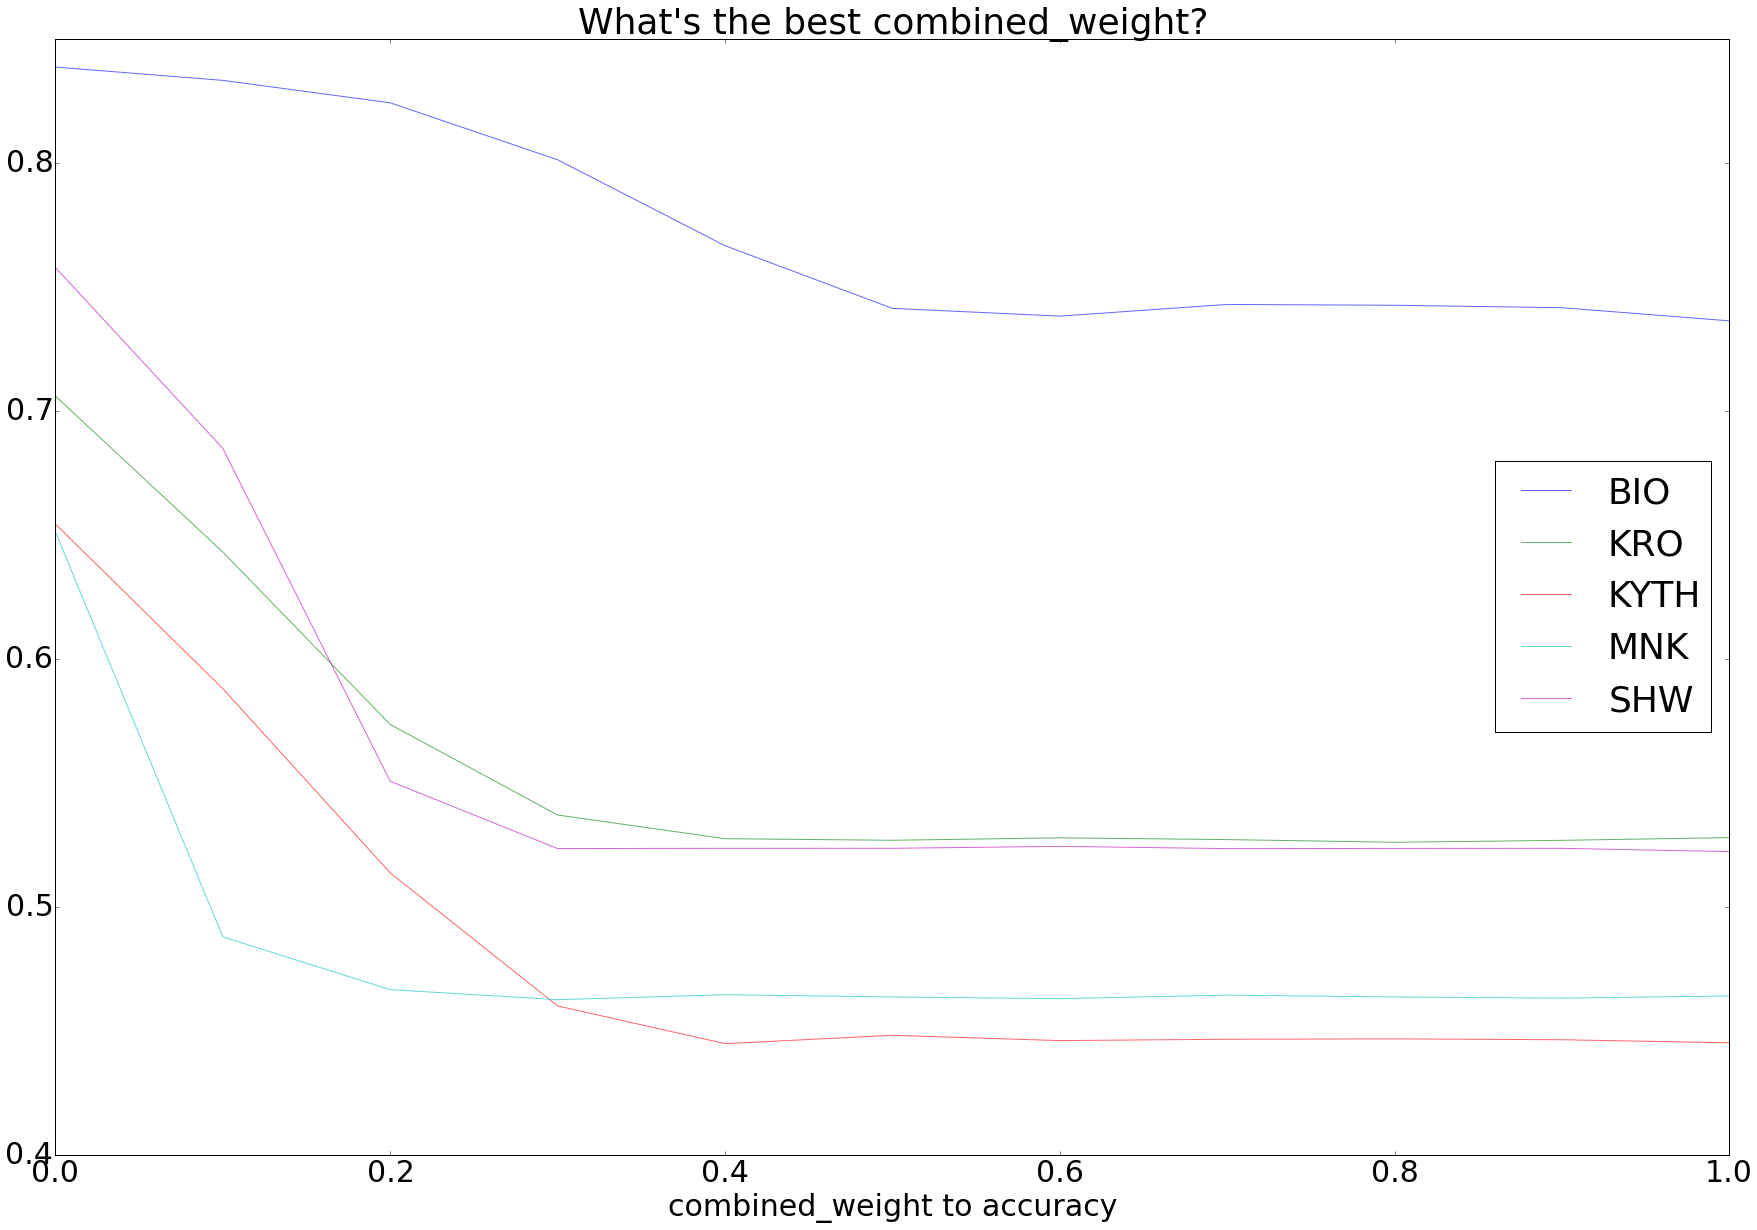

In [41]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in sct_results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('combined_weight').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('combined_weight to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best combined_weight?" )

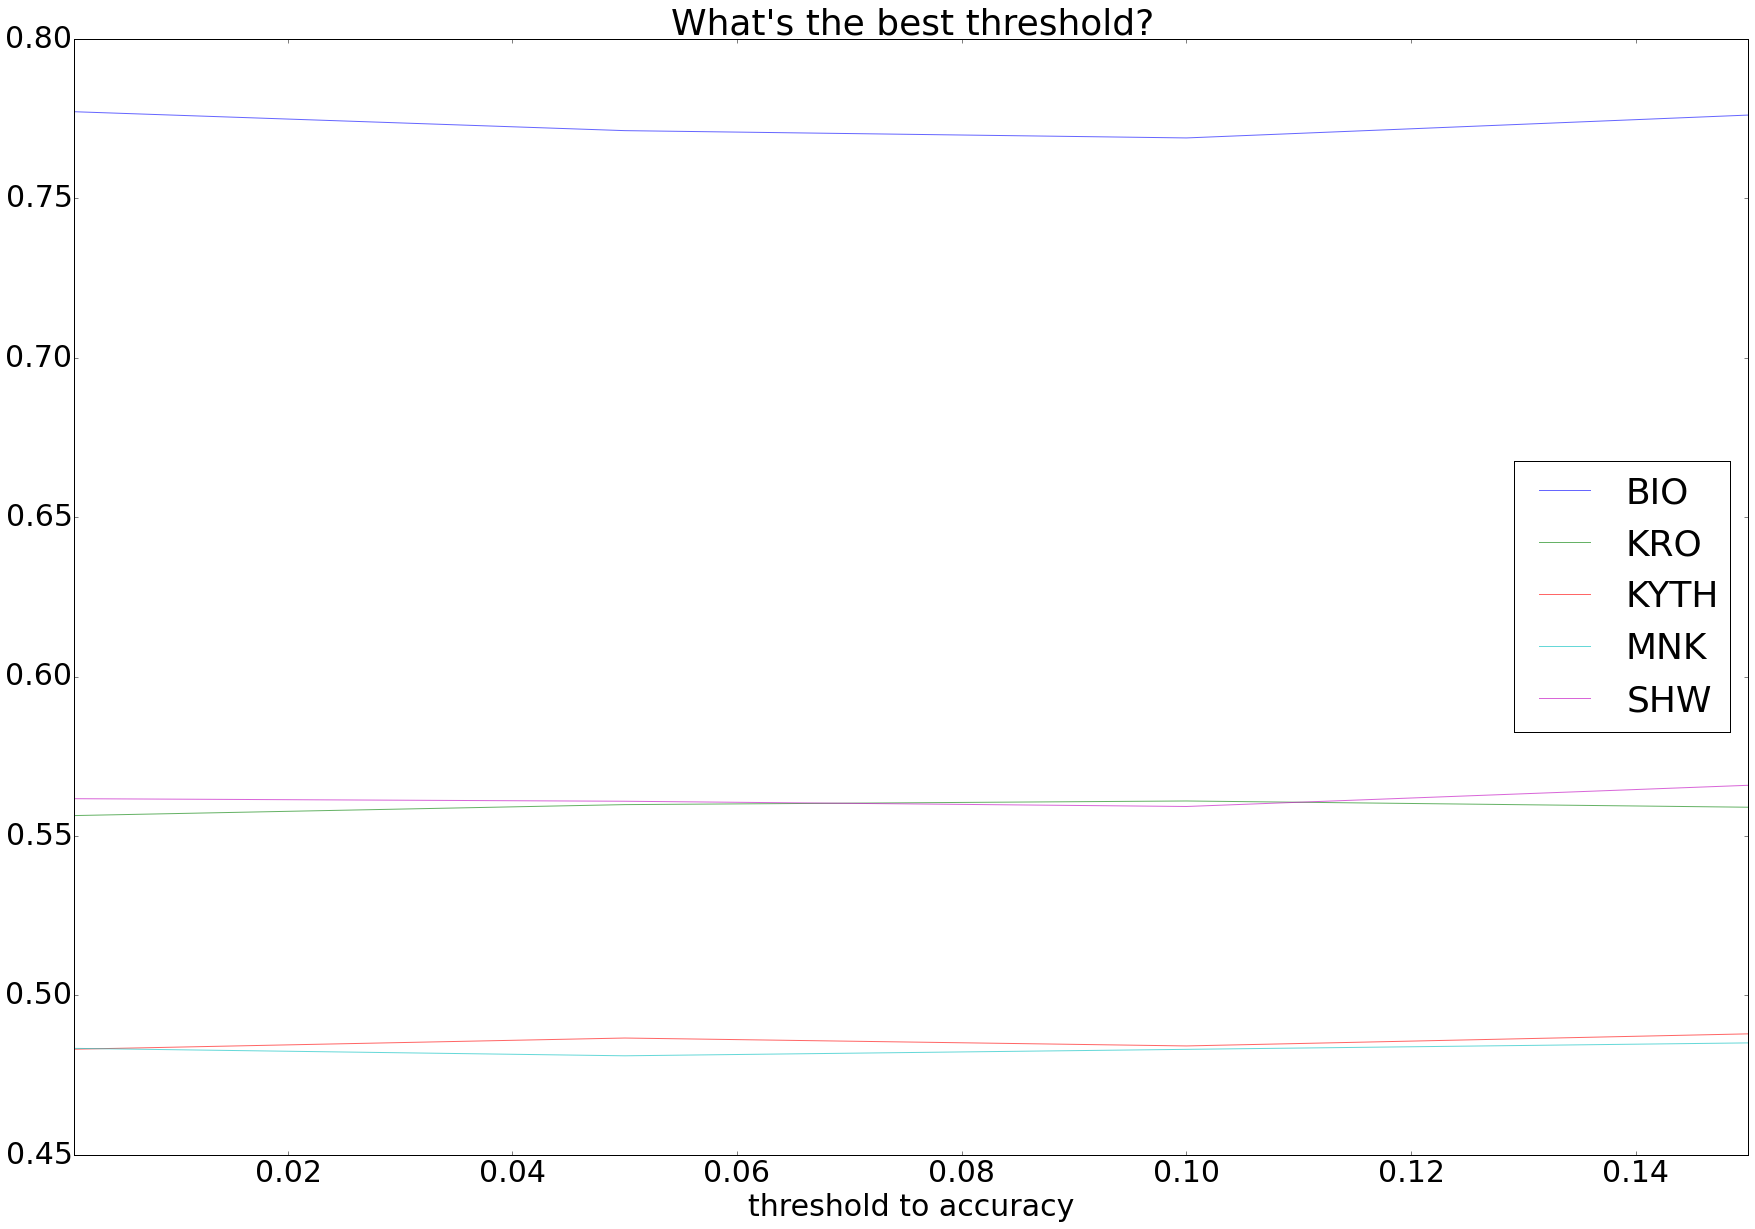

In [42]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in sct_results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('threshold').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('threshold to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best threshold?" )

 ## Find best decision tree
 We take the forth best desicion trees that we found and add to them two other trees (six in total).
 We "feed" them to the best strength classifer to find the best one.

In [89]:
import Classifiers.classifiers
import sklearn.tree

criterion=['entropy','gini']
min_samples_leaf=[0.02]
max_depth = [8]

bdt_model = [Classifiers.classifiers.ConnectionStrengthClassifier(threshold=0.001, base_strength=0.1, combined_weight=0, 
                                                                   base_estimator=sklearn.tree.DecisionTreeClassifier(criterion=c,min_samples_leaf=msl, max_depth=md)) 
          for c, msl, md in product(criterion, min_samples_leaf, max_depth)]

# model = Classifiers.classifiers.ConnectionStrengthClassifier(base_estimator=sklearn.tree.DecisionTreeClassifier())
# st_accuracies = run_strength_model(model)

In [90]:
bdt_accuracies = list(map(run_strength_model, bdt_model))

In [91]:
print(get_best_model(bdt_model, bdt_accuracies))
print(get_best_median_model(bdt_model, bdt_accuracies))

(4.0446150241086718, ConnectionStrengthClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.02,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
               base_strength=0.1, combined_weight=0, threshold=0.001))
(0.79968101409056913, ConnectionStrengthClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.02,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
               base_strength=0.1, combined_weight=0, threshold=0.001))


## Roc

In [80]:
trues = [(d.loc[c.index[c == True]], c.loc[c.index[c == True]]) for d, c in stocks]
falses = [(d.loc[c.index[c == False]], c.loc[c.index[c == False]]) for d, c in stocks]

In [81]:
print(len(trues[0][0]), len(tree_stocks[0][0]))
print(len(falses[0][0]), len(tree_stocks[0][0]))

1574 7855
6281 7855


In [94]:
true_scores = []
false_scores = []
model = Classifiers.classifiers.ConnectionStrengthClassifier(threshold=0.001, base_strength=0.1, combined_weight=0, 
                                                                   base_estimator=sklearn.tree.DecisionTreeClassifier())
for (fd, fc), (d, c), st, cs in zip(stocks, trues, strengths, connections_cols):
    c[0]= False
    true_scores.append(get_best_model(bdt_model, bdt_accuracies)[1].fit(fd, fc, cs, st).score(d, c))

for (fd, fc), (d, c), st, cs in zip(stocks, falses, strengths, connections_cols):
    c[0]= True
    false_scores.append(get_best_model(bdt_model, bdt_accuracies)[1].fit(fd, fc, cs, st).score(d.fillna(0), c))

In [95]:
print(true_scores)
print(false_scores)

[0.00063532401524777639, 0.1728395061728395, 0.0046189376443418013, 0.0, 0.0031007751937984496]
[0.99984078968317147, 0.98021308980213084, 0.99958018471872379, 1.0, 0.99961165048543688]


In [104]:
true_scores = []
false_scores = []
model = Classifiers.classifiers.ConnectionStrengthClassifier(threshold=0.01, base_strength=0.1, combined_weight=0, 
                                                                   base_estimator=sklearn.tree.DecisionTreeClassifier())
for (fd, fc), (d, c), st, cs in zip(stocks, trues, strengths, connections_cols):
    c[0]= False
    true_scores.append(model.fit(fd, fc, cs, st).score(d, c))

for (fd, fc), (d, c), st, cs in zip(stocks, falses, strengths, connections_cols):
    c[0]= True
    false_scores.append(model.fit(fd, fc, cs, st).score(d.fillna(0), c))

In [106]:
print(true_scores)
print(false_scores)

[0.3005082592121982, 0.32098765432098764, 0.302540415704388, 0.25517241379310346, 0.32093023255813952]
[0.82439102053813085, 0.82952815829528159, 0.87321578505457598, 0.81675392670157065, 0.82990291262135918]


In [107]:
true_scores = []
false_scores = []
model = Classifiers.classifiers.ConnectionStrengthClassifier(threshold=0.01, base_strength=0.1, combined_weight=0, 
                                                                   base_estimator=sklearn.tree.DecisionTreeClassifier(min_samples_leaf=0.01))
for (fd, fc), (d, c), st, cs in zip(stocks, trues, strengths, connections_cols):
    c[0]= False
    true_scores.append(model.fit(fd, fc, cs, st).score(d, c))

for (fd, fc), (d, c), st, cs in zip(stocks, falses, strengths, connections_cols):
    c[0]= True
    false_scores.append(model.fit(fd, fc, cs, st).score(d.fillna(0), c))

In [108]:
print(true_scores)
print(false_scores)

[0.0031766200762388818, 0.21604938271604937, 0.016166281755196306, 0.07586206896551724, 0.012403100775193798]
[0.99952236904951441, 0.954337899543379, 0.99790092359361882, 0.97382198952879584, 0.99961165048543688]


In [111]:
true_scores = []
false_scores = []
model = Classifiers.classifiers.ConnectionStrengthClassifier(threshold=0.01, base_strength=0.1, combined_weight=0, 
                                                                   base_estimator=sklearn.tree.DecisionTreeClassifier(max_depth=13))
for (fd, fc), (d, c), st, cs in zip(stocks, trues, strengths, connections_cols):
    c[0]= False
    true_scores.append(model.fit(fd, fc, cs, st).score(d, c))

for (fd, fc), (d, c), st, cs in zip(stocks, falses, strengths, connections_cols):
    c[0]= True
    false_scores.append(model.fit(fd, fc, cs, st).score(d.fillna(0), c))

In [112]:
print(true_scores)
print(false_scores)

[0.19695044472681067, 0.30864197530864196, 0.25173210161662818, 0.24827586206896551, 0.30232558139534882]
[0.92819614711033271, 0.85692541856925419, 0.92401343408900083, 0.82547993019197208, 0.8559223300970874]


In [116]:
true_scores = []
false_scores = []

max_depth=[6,8,10,12,14,16,18]

models = [Classifiers.classifiers.ConnectionStrengthClassifier(threshold=0.01, base_strength=0.1, combined_weight=0, 
                                                                   base_estimator=sklearn.tree.DecisionTreeClassifier(max_depth=md))
         for md in max_depth]

for m in models:
    true_scores.append([])
    for (fd, fc), (d, c), st, cs in zip(stocks, trues, strengths, connections_cols):
        c[0]= False
        true_scores[-1].append(m.fit(fd, fc, cs, st).score(d, c))

    false_scores.append([])
    for (fd, fc), (d, c), st, cs in zip(stocks, falses, strengths, connections_cols):
        c[0]= True
        false_scores[-1].append(m.fit(fd, fc, cs, st).score(d.fillna(0), c))


In [117]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

In [122]:
for t,f,m in zip(true_scores,false_scores,max_depth):
    print("max depth: "+str(m)+" score: "+str(100*(mean(f)*0.8+mean(t)*0.2))+" True positive: "+str(mean(t))+" False positive: "+str(mean(f)))

max depth: 6 score: 80.45182147485264 True positive: 0.07557758794460151 False positive: 0.9867533714495076
max depth: 8 score: 79.70730438338559 True positive: 0.12066811111267621 False positive: 0.9661742770141508
max depth: 10 score: 78.44663404040733 True positive: 0.1704894822431209 False positive: 0.9379605549443113
max depth: 12 score: 76.50097924745991 True positive: 0.2331263009272464 False positive: 0.8979806653614372
max depth: 14 score: 74.78589004677094 True positive: 0.2748507974538084 False positive: 0.8661109262211847
max depth: 16 score: 73.59670265715175 True positive: 0.2871623651769627 False positive: 0.8481681919201562
max depth: 18 score: 73.07957619822176 True positive: 0.2940214154669128 False positive: 0.8399893486110438


## Train

In [129]:
true_scores = []
false_scores = []

max_depth=[6,8,10,12,14,16,18]

models = [Classifiers.classifiers.ConnectionStrengthClassifier(threshold=0.01, base_strength=0.1, combined_weight=0, 
                    base_estimator=sklearn.tree.DecisionTreeClassifier(max_depth=md)) for md in max_depth]

train_data = [(d.iloc[0:round(len(d)*0.7)], c.iloc[0:round(len(d)*0.7)]) for d, c in stocks]
test_data = [(d.iloc[round(len(d)*0.7):len(d)-1], c.iloc[round(len(d)*0.7):len(d)-1]) for d, c in stocks]
trues = [(d.loc[c.index[c == True]], c.loc[c.index[c == True]]) for d, c in test_data]
falses = [(d.loc[c.index[c == False]], c.loc[c.index[c == False]]) for d, c in test_data]

for m in models:
    true_scores.append([])
    false_scores.append([])
    for (d, c), st, cs, (td, tc), (fd, fc) in zip(train_data, strengths, connections_cols, trues, falses):
        m.fit(d, c, cs, st)
        tc[0]= False
        fc[0]= True
        true_scores[-1].append(m.score(td, tc))
        false_scores[-1].append(m.score(fd.fillna(0), fc))

In [130]:
for t,f,m in zip(true_scores, false_scores, max_depth):
    print("max depth: "+str(m)+" score: "+str(100*(mean(f)*0.8+mean(t)*0.2))+" True positive: "+str(mean(t))+" True negative: "+str(mean(f)))

max depth: 6 score: 79.87372089824262 True positive: 0.05143162443343276 False positive: 0.9855636051196746
max depth: 8 score: 79.49364494568752 True positive: 0.0559770789788873 False positive: 0.9796762920763721
max depth: 10 score: 78.88059514895687 True positive: 0.08163797624918782 False positive: 0.9655979452996639
max depth: 12 score: 78.7800590900257 True positive: 0.08456854778735429 False positive: 0.9636086016784826
max depth: 14 score: 78.4508666179 True positive: 0.1044208293213718 False positive: 0.9545306253934072
max depth: 16 score: 77.6820858514869 True positive: 0.10972389876549009 False positive: 0.9435950984522137
max depth: 18 score: 77.6864895351726 True positive: 0.1184120460612323 False positive: 0.9414781076743493


In [197]:
import importlib as imp
imp.reload(Utilities.confusion_matrix)
cm = Utilities.confusion_matrix.ConfusionMatrix(stocks)

<module 'Utilities.confusion_matrix' from 'C:\\Users\\sdshw\\Desktop\\Stockfier\\stockifier\\Utilities\\confusion_matrix.py'>

In [198]:
cm = Utilities.confusion_matrix.ConfusionMatrix(stocks)

2


In [141]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold 

In [139]:
true_scores = []
false_scores = []

max_depth=[6]

kf = KFold(n_splits=3)
train_index, test_index = kf(stocks)

models = [Classifiers.classifiers.ConnectionStrengthClassifier(threshold=0.01, base_strength=0.1, combined_weight=0, 
                    base_estimator=sklearn.tree.DecisionTreeClassifier(max_depth=md)) for md in max_depth]

# train_data = [(d.iloc[0:round(len(d)*0.7)], c.iloc[0:round(len(d)*0.7)]) for d, c in stocks]
# test_data = [(d.iloc[round(len(d)*0.7):len(d)-1], c.iloc[round(len(d)*0.7):len(d)-1]) for d, c in stocks]
# trues = [(d.loc[c.index[c == True]], c.loc[c.index[c == True]]) for d, c in test_data]
# falses = [(d.loc[c.index[c == False]], c.loc[c.index[c == False]]) for d, c in test_data]

for m in models:
    true_scores.append([])
    false_scores.append([])
    for (d, c), st, cs, (td, tc) in zip(train_data, strengths, connections_cols, test_data):
        y_pred = m.fit(d, c, cs, st).predict(td)
        # f_pred = m.predict(fd.fillna(0))
        tc[0]= False
        fc[0]= True
#         true_scores[-1].append(m.score(td, tc))
#         false_scores[-1].append(m.score(fd.fillna(0), fc))
    cnf_matrix_t = confusion_matrix(tc, y_pred)


In [167]:
models = [Classifiers.classifiers.ConnectionStrengthClassifier(threshold=0.01, base_strength=0.1, combined_weight=0, 
                    base_estimator=sklearn.tree.DecisionTreeClassifier(max_depth=6)) for md in max_depth]


train_data = [(d.iloc[0:round(len(d)*0.7)], c.iloc[0:round(len(d)*0.7)]) for d, c in stocks]
test_data = [(d.iloc[round(len(d)*0.7):len(d)-1], c.iloc[round(len(d)*0.7):len(d)-1]) for d, c in stocks]
cnf_matrix_t =[]
true_scores.append([])
false_scores.append([])
for (d, c), st, cs, (td, tc) in zip(train_data, strengths, connections_cols, test_data):
    y_pred = m.fit(d, c, cs, st).predict(td)
    # f_pred = m.predict(fd.fillna(0))
#     tc[0]= False
#     fc[0]= True
    cnf_matrix_t.append(confusion_matrix(y_pred,tc))
    

In [168]:
print(cnf_matrix_t)

[array([[1958,  392],
       [   3,    3]]), array([[167,  60],
       [  9,   9]]), array([[794,  49],
       [  1,   0]]), array([[181,  30],
       [  3,   0]]), array([[833, 132],
       [  0,   0]])]


In [178]:
import numpy
d= numpy.zeros((2,2))
for c in cnf_matrix_t:
    d[0][0] = c[0][0]/(c[1][0]+c[0][0])
    d[1][0] = c[1][0]/(c[1][0]+c[0][0])
    d[0][1] = c[0][1]/(c[1][1]+c[0][1])
    d[1][1] = c[1][1]/(c[1][1]+c[0][1])
    print(d)

[[ 0.99847017  0.99240506]
 [ 0.00152983  0.00759494]]
[[ 0.94886364  0.86956522]
 [ 0.05113636  0.13043478]]
[[ 0.99874214  1.        ]
 [ 0.00125786  0.        ]]
[[ 0.98369565  1.        ]
 [ 0.01630435  0.        ]]
[[ 1.  1.]
 [ 0.  0.]]


In [170]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [172]:
for c in cnf_matrix_t:
    plot_confusion_matrix(c, normalize=True,
                      title='Normalized confusion matrix')

TypeError: plot_confusion_matrix() missing 1 required positional argument: 'classes'

In [279]:
import importlib as imp
imp.reload(Utilities.confusion_matrix)
cm = [Utilities.confusion_matrix.ConfusionMatrix(s, model, st, cc) for s,st,cc in zip(stocks, strengths, connections_cols)]


<module 'Utilities.confusion_matrix' from 'C:\\Users\\sdshw\\Desktop\\Stockfier\\stockifier\\Utilities\\confusion_matrix.py'>

27
27
27
27
27


ConnectionStrengthClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=13,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
               base_strength=0.1, combined_weight=0, threshold=0.01)
Accuracy: 69.6357348546


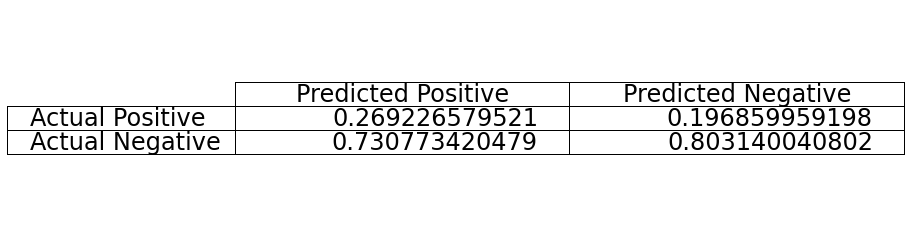

ConnectionStrengthClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=13,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
               base_strength=0.1, combined_weight=0, threshold=0.01)
Accuracy: 69.1260801564


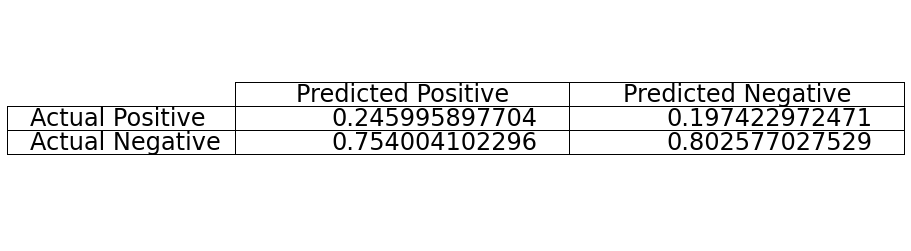

ConnectionStrengthClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=13,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
               base_strength=0.1, combined_weight=0, threshold=0.01)
Accuracy: 73.123122172


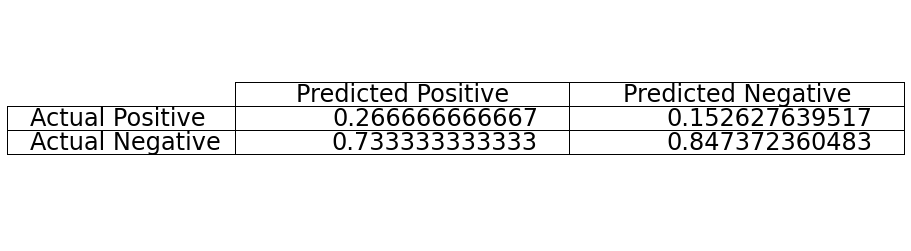

ConnectionStrengthClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=13,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
               base_strength=0.1, combined_weight=0, threshold=0.01)
Accuracy: 69.3586601235


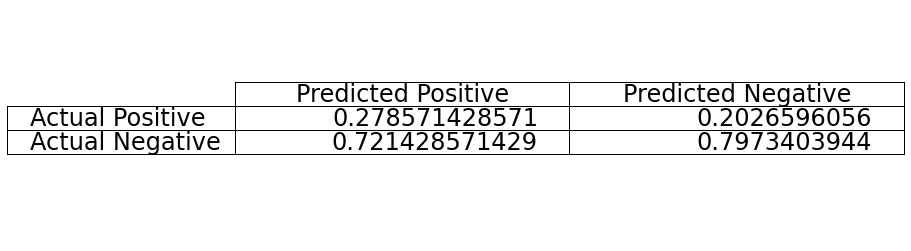

ConnectionStrengthClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=13,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
               base_strength=0.1, combined_weight=0, threshold=0.01)
Accuracy: 70.1101676604


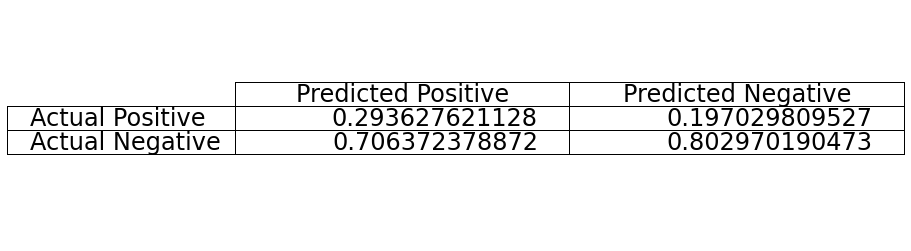

In [280]:
for c in cm:
    c.plot()

In [240]:
models = [Classifiers.classifiers.ConnectionStrengthClassifier(threshold=0.01, base_strength=0.1, combined_weight=0, 
                    base_estimator=sklearn.tree.DecisionTreeClassifier(max_depth=10)) for md in max_depth]



res = cm.calc_mat(models=models,strengths=strengths,connections_cols=connections_cols)

C:\Users\sdshw\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:375: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

C:\Users\sdshw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\sdshw\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.



ZeroDivisionError: Weights sum to zero, can't be normalized

In [235]:
for r in res:
    print(r)

[[ 0.8372896   0.1627104 ]
 [ 0.53846154  0.46153846]]
[[ 0.73755656  0.26244344]
 [ 0.54166667  0.45833333]]
[[ 0.94180523  0.05819477]
 [ 1.          0.        ]]
[[ 0.85365854  0.14634146]
 [ 1.          0.        ]]
[[ 0.86638831  0.13361169]
 [ 0.42857143  0.57142857]]


ConnectionStrengthClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
               base_strength=0.1, combined_weight=0, threshold=0.01)
Accuracy: 76.2139371203
ConnectionStrengthClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
               base_strength=0.1, combined_weight=0, threshold=0.01)
Accuracy: 68.1711915535
ConnectionStrengthClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', 

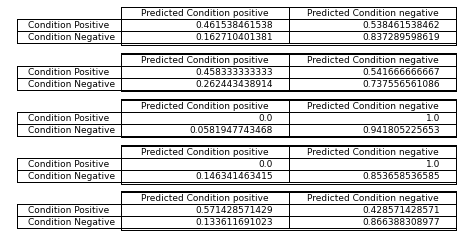

In [236]:
cm.plot()

In [217]:

from IPython.core.interactiveshell import InteractiveShell